# The big test: zero Shot model against SARIMA and XG boost. Predict tomatoe price for the big nepali tomatoe

In [ ]:
# prompt: the df show me tomoatoe (commodity column over time bases on month (for the aggreagte by taking the average fo that month

import zipfile
import pandas as pd

# Unzip the file
with zipfile.ZipFile('/content/kalimati_tarkari_dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/kalimati_tarkari_dataset.csv')
#df

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5
1,1,Tomato Small(Local),2013-06-16,Kg,26.0,32.0,29.0
2,2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5
3,3,Potato White,2013-06-16,Kg,15.0,16.0,15.5
4,4,Onion Dry (Indian),2013-06-16,Kg,28.0,30.0,29.0
...,...,...,...,...,...,...,...
197156,197156,Garlic Dry Nepali,2021-05-13,Kg,100.0,120.0,110.0
197157,197157,Fish Fresh(Rahu),2021-05-13,KG,270.0,280.0,275.0
197158,197158,Fish Fresh(Bachuwa),2021-05-13,KG,225.0,235.0,230.0
197159,197159,Fish Fresh(Chhadi),2021-05-13,KG,220.0,230.0,225.0


In [ ]:

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Extract the month from the 'Date' column
df['Year-Month'] = df['Date'].dt.strftime('%Y-%m')

# Filter for 'Tomato' commodity
tomato_df = df[df['Commodity'] == 'Tomato Big(Nepali)']

# Group by month and calculate the average price
monthly_avg_price = tomato_df.groupby('Year-Month')['Average'].mean()

# Display the result
average_prices = monthly_avg_price.sort_index()
average_prices


,Average
Year-Month,
2013-06,30.227273
2013-07,54.700000
2013-08,43.523810
2013-09,40.300000
2013-10,50.462963
...,...
2021-01,46.500000
2021-02,50.277778
2021-03,46.346154


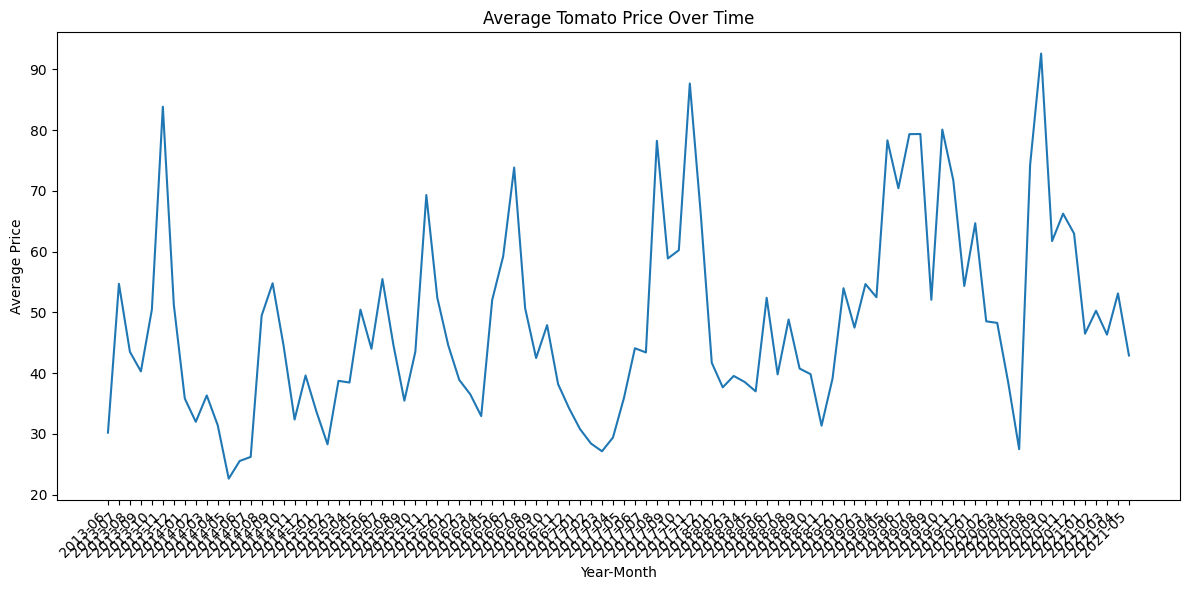

In [ ]:
# prompt: display average_prices over YearMonth

import matplotlib.pyplot as plt

# Assuming 'average_prices' Series is already created as in your previous code

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(average_prices.index, average_prices.values)
plt.xlabel('Year-Month')
plt.ylabel('Average Price')
plt.title('Average Tomato Price Over Time')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(average_prices.dropna())
print(f"ADF p-value: {result[1]}")


ADF p-value: 1.811637228728876e-05


✅ Interpretation:
Null hypothesis: The series is non-stationary

Alternative hypothesis: The series is stationary

Since p-value < 0.05 → we reject the null → your series is stationary.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(average_prices, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            Average   No. Observations:                   94
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -327.199
Date:                            Thu, 17 Apr 2025   AIC                            664.398
Time:                                    22:52:19   BIC                            676.370
Sample:                                         0   HQIC                           669.201
                                             - 94                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4388      0.124      3.546      0.000       0.196       0.681
ma.L1         -0.9998     15.441   

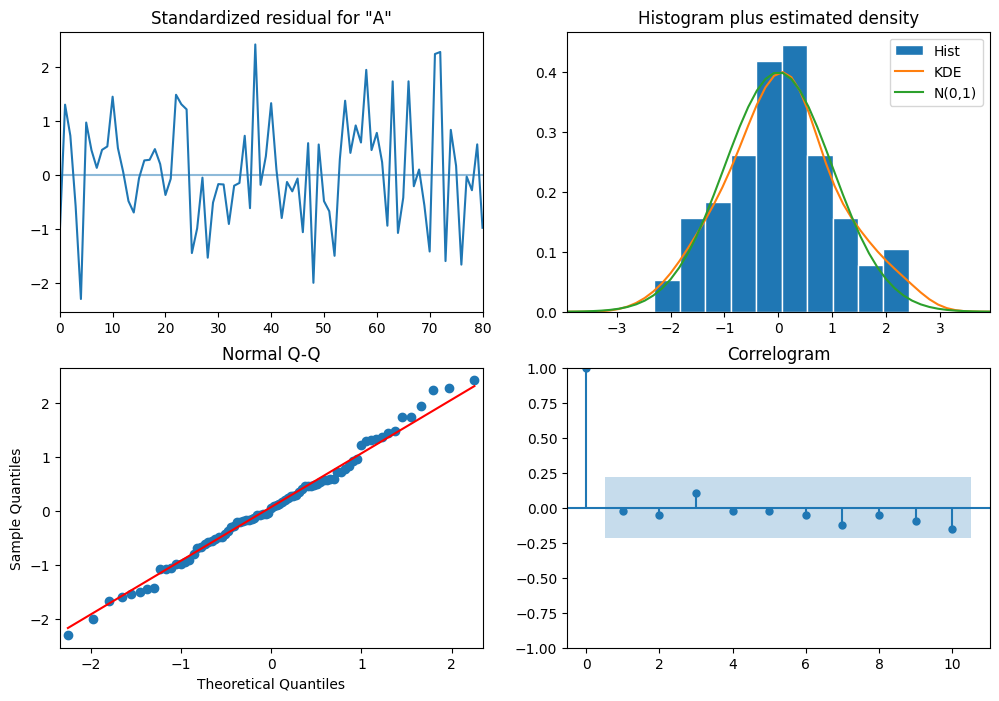

In [ ]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()


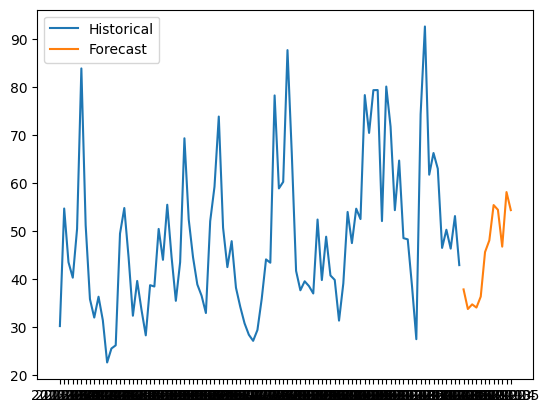

In [ ]:
# Suppose your original series was called `ts`
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean

# Fix the forecast index to continue from your last observation
last_date = average_prices.index[-1]

# Convert last_date to Timestamp before adding DateOffset
last_date = pd.Timestamp(last_date)  # Convert to Timestamp

# forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Create a new index with the correct frequency
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS').strftime('%Y-%m')

forecast_mean.index = forecast_index

# Now plot it
plt.plot(average_prices, label='Historical')
plt.plot(forecast_mean, label='Forecast')
plt.legend()
plt.show()

<ipython-input-128-4176e4db7d89>:14: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast')


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7ca1bb2a0310>.

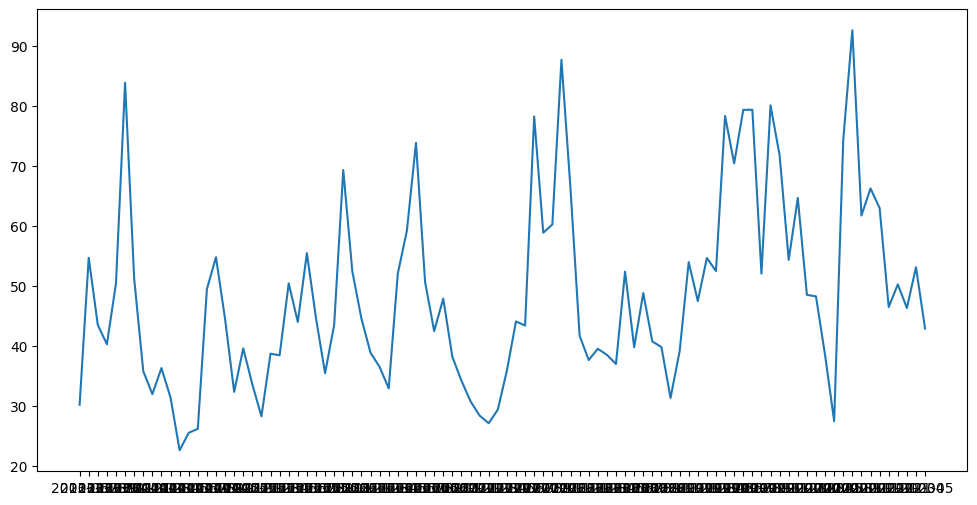

In [ ]:
import matplotlib.dates as mdates

# Ensure your forecast index is proper datetime
# Try explicitly providing the 'utc' keyword argument to ensure consistent timezone handling
forecast_mean.index = pd.to_datetime(forecast_mean.index, utc=True)

# Plot with explicit datetime handling
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(average_prices.index, average_prices, label='Historical')

# Plot forecast - explicitly using the index and values
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast')

# Format x-axis for better date display
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate dates

plt.title('Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Step-by-step Plan to Compare TapPFN with **SARIM**

In [ ]:
!pip install tabpfn-time-series

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

# STEP 1: Convert your single series to a TimeSeriesDataFrame
# We give it an item_id so it can work with AutoGluon/TabPFN format
df = average_prices.reset_index()
df.columns = ['timestamp', 'target']
df['item_id'] = 'series_1'  # Assign a fixed ID

# Required format for TimeSeriesDataFrame: columns = ['item_id', 'timestamp', 'target']
df = df[['item_id', 'timestamp', 'target']]
tsdf = TimeSeriesDataFrame(df)

# STEP 2: Train/test split
prediction_length = 12  # Change this as needed (e.g. 12 months)
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)

# STEP 3: Generate test inputs (X) for TabPFN
test_tsdf = generate_test_X(train_tsdf, prediction_length=prediction_length)


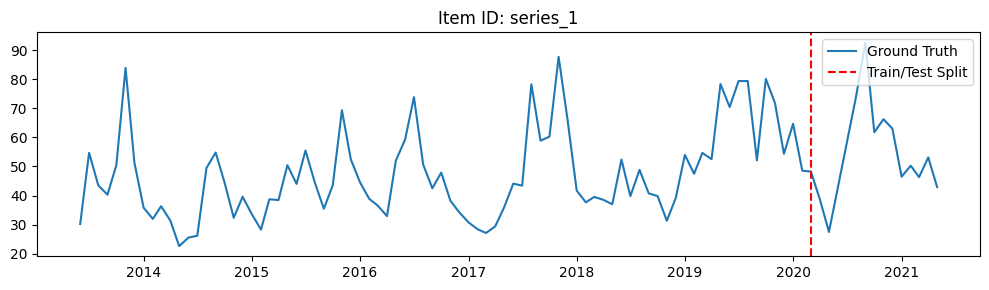

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [ ]:
from tabpfn_time_series import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]

train_tsdf, test_tsdf = FeatureTransformer.add_features(
    train_tsdf, test_tsdf, selected_features
)


In [ ]:
train_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id  timestamp                                                     
series_1 2013-06-01  30.227273              0  2013              0.0   
         2013-07-01  54.700000              1  2013              0.0   
         2013-08-01  43.523810              2  2013              0.0   
         2013-09-01  40.300000              3  2013              0.0   
         2013-10-01  50.462963              4  2013              0.0   

                     hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id  timestamp                                                       
series_1 2013-06-01              1.0    -8.660254e-01              0.5   
         2013-07-01              1.0     0.000000e+00              1.0   
         2013-08-01              1.0     1.224647e-16             -1.0   
         2013-09-01              1.0    -2.449294e-16              1.0   
         2013-10-01              1.0     8.660254e-01              0.5   

                     day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id  timestamp                                                         
series_1 2013-06-01               0.0               1.0         0.509933   
         2013-07-01               0.0               1.0         0.017261   
         2013-08-01               0.0               1.0        -0.495009   
         2013-09-01               0.0               1.0        -0.868888   
         2013-10-01               0.0               1.0        -1.000000   

                     day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id  timestamp                                                         
series_1 2013-06-01    -8.602144e-01          0.526432         -0.850217   
         2013-07-01    -9.998510e-01         -0.061561         -0.998103   
         2013-08-01    -8.688880e-01         -0.526432         -0.850217   
         2013-09-01    -4.950088e-01         -0.866025         -0.500000   
         2013-10-01    -1.836970e-16         -0.995734          0.092268   

                     month_of_year_sin  month_of_year_cos  
item_id  timestamp                                         
series_1 2013-06-01           0.281733          -0.959493  
         2013-07-01          -0.281733          -0.959493  
         2013-08-01          -0.755750          -0.654861  
         2013-09-01          -0.989821          -0.142315  
         2013-10-01          -0.909632           0.415415

In [ ]:
test_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id  timestamp                                                  
series_1 2020-04-01     NaN             82  2020              0.0   
         2020-05-01     NaN             83  2020              0.0   
         2020-06-01     NaN             84  2020              0.0   
         2020-07-01     NaN             85  2020              0.0   
         2020-08-01     NaN             86  2020              0.0   

                     hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id  timestamp                                                       
series_1 2020-04-01              1.0         0.866025             -0.5   
         2020-05-01              1.0        -0.866025             -0.5   
         2020-06-01              1.0         0.000000              1.0   
         2020-07-01              1.0         0.866025             -0.5   
         2020-08-01              1.0        -0.866025              0.5   

                     day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id  timestamp                                                         
series_1 2020-04-01               0.0               1.0     1.000000e+00   
         2020-05-01               0.0               1.0     8.688880e-01   
         2020-06-01               0.0               1.0     4.950088e-01   
         2020-07-01               0.0               1.0     1.224647e-16   
         2020-08-01               0.0               1.0    -5.099326e-01   

                     day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id  timestamp                                                         
series_1 2020-04-01     6.123234e-17          0.999526         -0.030795   
         2020-05-01    -4.950088e-01          0.866025         -0.500000   
         2020-06-01    -8.688880e-01          0.417960         -0.908465   
         2020-07-01    -1.000000e+00         -0.061561         -0.998103   
         2020-08-01    -8.602144e-01         -0.526432         -0.850217   

                     month_of_year_sin  month_of_year_cos  
item_id  timestamp                                         
series_1 2020-04-01           0.989821          -0.142315  
         2020-05-01           0.755750          -0.654861  
         2020-06-01           0.281733          -0.959493  
         2020-07-01          -0.281733          -0.959493  
         2020-08-01          -0.755750          -0.654861

Prediction

In [ ]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.CLIENT,
)

pred = predictor.predict(train_tsdf, test_tsdf)

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 292.33it/s]


## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

# Assuming 'pred', 'train_tsdf', and 'test_tsdf_ground_truth' are defined

# Check the lengths of your DataFrames:
print(f"Length of pred: {len(pred)}")
print(f"Length of test_tsdf_ground_truth: {len(test_tsdf_ground_truth)}")

# If the lengths are different, adjust your prediction_length or data splitting accordingly.

# If using item_ids, ensure they are consistent:
# print(f"Unique item_ids in pred: {pred['item_id'].unique()}")
# print(f"Unique item_ids in test_tsdf_ground_truth: {test_tsdf_ground_truth['item_id'].unique()}")

# If item_ids differ, filter your DataFrames to have matching item_ids.

# Assuming the issue is with the length, adjust your prediction_length or
# data splitting in your earlier code blocks.
# In the absence of item_ids, the error mostly stems from size inconsistencies.


# Once lengths are confirmed to be the same, try plotting again.
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

Length of pred: 12
Length of test_tsdf_ground_truth: 94


ValueError: Pred and Test have different number of items and Pred is not a subset of Test